<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [1]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    print(f"adding project root {project_root} to path")
    sys.path.append(project_root)

adding project root /Users/mike/Projects/learning/pytorch-deep-learning to path


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.9.1
torchvision version: 0.24.1


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [7]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x320e80380>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

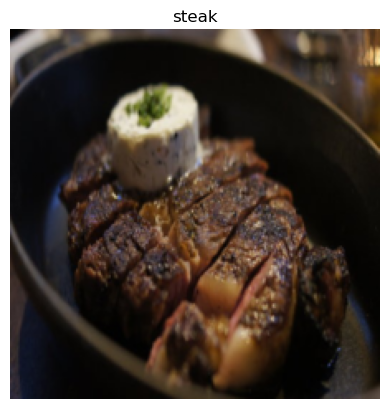

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [11]:
from torch import nn
from torchinfo import summary

class PatchEmbedding(nn.Module):
    def __init__(self, channels, width, height, patch_size):
        super().__init__()
        self.patch = nn.Conv2d(
            in_channels=channels,
            out_channels=((patch_size**2)*channels),
            kernel_size=patch_size,
            stride=patch_size
            )
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)
        
    def forward(self, x):
        return self.flatten(self.patch(x)).permute(0, 2, 1) # => Batch, Patch Num, Features

class ViT(nn.Module):
    def __init__(self, channels, width, height, patch_size, num_classes,
        nhead=12, dim_feedforward=3072, dropout=0.1, encoder_layers=12
        ):
        super().__init__()
        assert width % patch_size == 0, "Bad width"
        assert height % patch_size == 0, "Bad height"
        number_of_patches = int((height * width) / (patch_size**2))
        dimensions = (patch_size**2)*channels
        print(f"Size {width}x{height} | Patch: {patch_size}  | Num Patches: {number_of_patches} | Dimensions: {dimensions}")
        
        # 1. Patch Embedding - i.e split the image into chunks [1, 196, 768] -> Batch_N,Patch_N, Features 
        self.patch = PatchEmbedding(channels, width, height, patch_size)
        # 2. Add Class embedding to all the images -> [1,197,768]
        self.class_token =  nn.Parameter(data=torch.randn(1, 1, dimensions), requires_grad=True)
        # 3. Add Positional embedding 
        self.positional_embedding = nn.Parameter(data=torch.randn(1, number_of_patches+1, dimensions), requires_grad=True)
        # 4. Embedding dropout
        self.embedding_dropout = nn.Dropout(p=dropout)
        # 5. Encoder layer
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=dimensions,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True)
        # 6. Encoder layer
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=transformer_encoder_layer,
            num_layers=encoder_layers
            )
        # Create MLP Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=dimensions),
            nn.Linear(in_features=dimensions, out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch(x)
        # print(f"X.shape after patch = {x.shape}")
        class_token = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_token, x), dim=1) 
        # print(f"X.shape after cat = {x.shape}, class.token = {class_token.shape}")
        x = self.positional_embedding + x
        # print(f"X.shape positional emdedding addition = {x.shape}, positional_embedding: {self.positional_embedding.shape}")
        x = self.embedding_dropout(x)
        # print(f"X.shape dropout = {x.shape}")

        x = self.transformer_encoder(x)
        # print(f"X.shape Transformer encoder = {x.shape}")
        # print(f"Head shape {x[:,0].shape}")
        y = self.mlp_head(x[:,0])
        return y


# summary(t_encoder_layer, input_size=(2, 3,768) )

In [12]:
#summary(vit, input_size=(32, channels, width, height))

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [13]:
from pathlib import Path


train_20_dir = Path('data') / 'pizza_steak_sushi_20_percent' / 'train'
test_20_dir = Path('data') / 'pizza_steak_sushi_20_percent' / 'train'
train_dir, test_dir, train_20_dir, test_20_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'))

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [14]:
from going_modular.going_modular.data_setup import create_dataloaders
from torchvision import transforms
from torch import nn


weights = torchvision.models.ViT_B_16_Weights.DEFAULT
transforms = weights.transforms()

train_dataloader, test_dataloader, class_name = create_dataloaders(
    train_dir=train_20_dir,
    test_dir=test_20_dir,
    transform=transforms,
    batch_size=32
)


# Creating Manually
# transforms = transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.ToTensor(),
# ])
# transforms

# train_dataloader, test_dataloader, class_name = create_dataloaders(
#     train_dir=train_20_dir,
#     test_dir=test_20_dir,
#     transform=transforms,
#     batch_size=32
# )
# train_dataloader,test_dataloader




In [15]:
from going_modular.going_modular.engine import train

width = 224
height = 224
patch_size = 16
channels = 3

vit = torchvision.models.vit_b_16(weights=weights)

for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=len(class_names), bias=True),
  )

#summary(model=vit, input_size=(32,3,224,224))

# Create manually
#vit = ViT(channels=3, width=width, height=height, patch_size=patch_size , num_classes=len(class_names)).to(device)

epochs = 10

# res = train(
#     model=vit,
#     train_dataloader=train_dataloader, 
#     test_dataloader=test_dataloader, 
#     optimizer=torch.optim.Adam(lr=0.001, params=vit.parameters()),
#     loss_fn=nn.CrossEntropyLoss(),
#     epochs=epochs,
#     device=device
#     )
# res

# X,y = next(iter(train_dataloader))

# X.shape,  y.shape

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [20]:
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
transforms = weights.transforms()

vit2 = torchvision.models.vit_b_16(weights=weights)
for param in vit2.parameters():
    param.requires_grad = False

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_20_dir, test_dir=test_20_dir, transform=transforms, batch_size=32)
vit2.heads =  nn.Sequential(
    nn.Linear(in_features=768, out_features=3, bias=True)
  )
vit2
# summary(model=vit2, input_size=(1,3,384,384), col_names=["trainable"])

epochs = 10

res = train(
    model=vit2,
    train_dataloader=train_dataloader, 
    test_dataloader=test_dataloader, 
    optimizer=torch.optim.Adam(lr=0.001, params=vit2.parameters()),
    loss_fn=nn.CrossEntropyLoss(),
    epochs=epochs,
    device=device
    )
res

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3402 | train_acc: 0.8750 | test_loss: 0.0706 | test_acc: 0.9854
Epoch: 2 | train_loss: 0.0501 | train_acc: 0.9854 | test_loss: 0.0359 | test_acc: 0.9917
Epoch: 3 | train_loss: 0.0304 | train_acc: 0.9958 | test_loss: 0.0235 | test_acc: 0.9958
Epoch: 4 | train_loss: 0.0204 | train_acc: 0.9958 | test_loss: 0.0175 | test_acc: 0.9979
Epoch: 5 | train_loss: 0.0144 | train_acc: 0.9979 | test_loss: 0.0138 | test_acc: 0.9979
Epoch: 6 | train_loss: 0.0116 | train_acc: 0.9979 | test_loss: 0.0109 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0092 | train_acc: 1.0000 | test_loss: 0.0091 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0075 | train_acc: 1.0000 | test_loss: 0.0080 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0062 | train_acc: 1.0000 | test_loss: 0.0068 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0056 | train_acc: 1.0000 | test_loss: 0.0060 | test_acc: 1.0000


{'train_loss': [0.34021874361981946,
  0.05014863538866242,
  0.030363242326226707,
  0.020400892826728523,
  0.014383106038440018,
  0.011581532630953007,
  0.009157491583998005,
  0.007470053123446026,
  0.006196261909402286,
  0.005559649722029766],
 'train_acc': [0.875,
  0.9854166666666667,
  0.9958333333333333,
  0.9958333333333333,
  0.9979166666666667,
  0.9979166666666667,
  1.0,
  1.0,
  1.0,
  1.0],
 'test_loss': [0.07063939248522123,
  0.03585916095568488,
  0.023548885621130465,
  0.017477144238849482,
  0.013798985490575432,
  0.010871250256119918,
  0.00909927807127436,
  0.00801708666452517,
  0.006846979757150014,
  0.005980297977415224],
 'test_acc': [0.9854166666666667,
  0.9916666666666667,
  0.9958333333333333,
  0.9979166666666667,
  0.9979166666666667,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

In [15]:
# TODO: your explanations of the above terms